In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency

In [2]:
DEGREES = [3, 4]
PROBABILITIES = [0.5, 0.5]

MIN_DEG = min(DEGREES)
MAX_DEG = max(DEGREES)
LCM = math.lcm(*DEGREES)

In [3]:
def random_walk(n):
    return [np.random.randint(0,LCM-1) for _ in range(n)]

def height_in_constant_degree_tree(d, walk):
    height = 0
    
    for step in walk:
        if int(step * d / LCM) == 0 and height > 0:
            height -= 1
        else:
            height += 1
    
    return height

def min_height(walk):
    return height_in_constant_degree_tree(MIN_DEG, walk)

def max_height(walk):
    return height_in_constant_degree_tree(MAX_DEG, walk)

def walk_goes_higher_than(d, walk):
    return min_height(walk) > d

In [4]:
def UGW(height, degs=DEGREES, probs=PROBABILITIES):
    normalization = sum([ d * p for d, p in zip(degs, probs) ])
    offspring_probs = [ d * p / normalization for d, p in zip(degs, probs) ]
    
    T = nx.Graph()
    T.add_node('')
    
    root_deg = np.random.choice(degs, p=probs)
    current_level = [ str(i) for i in range(root_deg) ]
    T.add_edges_from([ ('', v) for v in current_level ])
    
    current_height = 1
    while current_height <= height:
        next_level = []
        
        for v in current_level:
            v_deg = np.random.choice(degs, p=offspring_probs)
            new_nodes = [ v + str(i) for i in range(1, v_deg)]
            next_level.extend(new_nodes)
            T.add_edges_from([ (v, u) for u in new_nodes ])
        
        current_level = next_level
        current_height += 1
    
    return T

In [5]:
def walk_in_tree(walk, tree):
    current_node = ''
    
    for step in walk:
        reduced_step = int(step * tree.degree[current_node] / LCM)
            
        if reduced_step == 0 and current_node != '':
            next_node = current_node[:-1]
        else:
            next_node = current_node + str(reduced_step)
        
        current_node = next_node
    
    return current_node

In [ ]:
def UGW_along_walk(height, walk, ball_radius, degs=DEGREES, probs=PROBABILITIES):
    normalization = sum([ d * p for d, p in zip(degs, probs) ])
    offspring_probs = [ d * p / normalization for d, p in zip(degs, probs) ]
    
    T = nx.Graph()
    T.add_node('')
    
    #TODO: write this function so that things can go faster
    
    pass

In [6]:
def ball(graph, root, radius):
    b = nx.Graph()
    b.add_edges_from(nx.bfs_edges(graph, root, depth_limit=radius))
    b.nodes[root]['root'] = True
    return b

def ball_node_match(n1, n2):
    return n1 == n2

In [7]:
def mappings(xs, ys):
    if len(xs) == 0:
        return [[]]
    else:
        x, *zs = xs
        
        smaller_mappings = mappings(zs, ys)
        return [
            [(x,y)] + sm
            for y in ys
            for sm in smaller_mappings
        ]

In [8]:
def possible_balls(radius, degs=DEGREES):
    if radius == 1:
        balls = []
        
        for d in degs:
            b = nx.Graph()
            b.add_edges_from([('', str(i)) for i in range(d)])
            b.nodes['']['root'] = True
            balls.append(b)
            
        return balls
    
    else:
        smaller_balls = possible_balls(radius-1, degs)
        balls = []
        
        for sb in smaller_balls:
            leaves = [node for node in sb if len(node) == radius-1]
            
            for m in mappings(leaves, degs):
                b = sb.copy()
                
                for l, d in m:
                    b.add_edges_from([(l, l+str(i)) for i in range(1,d)])
                
                if all([not nx.is_isomorphic(b, x, node_match=ball_node_match) for x in balls]):
                    balls.append(b)

        return balls

In [26]:
num_samples = 10
num_subsamples = 5000
ball_radius = 2
walk_length = 7

all_balls = possible_balls(ball_radius)
num_balls = len(all_balls)

samples = []

for _ in range(num_samples):
    w = random_walk(walk_length)
    while not walk_goes_higher_than(2 * ball_radius, w):
        w = random_walk(walk_length)
        
    ugw_height = max_height(w) + ball_radius
        
    statistic = np.zeros((num_balls, num_balls))
        
    for __ in range(num_subsamples):
        t = UGW(ugw_height)
        
        start = ''
        end = walk_in_tree(w, t)
        
        bstart = ball(t, start, ball_radius)
        bend = ball(t, end, ball_radius)
        
        for i, b1 in enumerate(all_balls):
            if nx.is_isomorphic(bstart, b1, node_match = ball_node_match):
                for j, b2 in enumerate(all_balls):
                    if nx.is_isomorphic(bend, b2, node_match = ball_node_match):
                        statistic[i,j] += 1
                        break
                break
        
    if int(statistic.sum()) != num_subsamples:
        raise Exception("at least one of the sampled balls did not match!")
    
    samples.append(statistic)

In [27]:
for sample in samples:
    try:
        stat, p, dof, expected = chi2_contingency(sample)
        print(p)
    except:
        print('something went wrong')

0.995022812072871
0.3311301451866121
0.45473650067266275
0.35580285806546685
0.9788205263585891
0.7653756157791506
0.3013666955723451
0.895802512217381
0.28416736755159483
0.5651779664841386


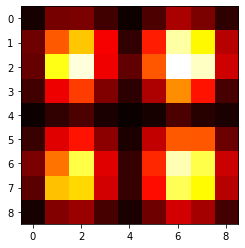

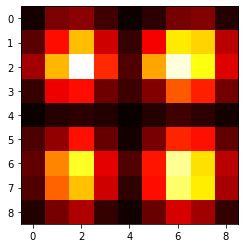

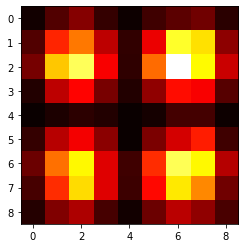

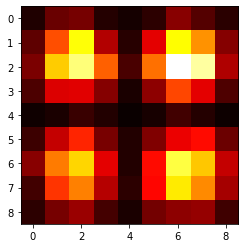

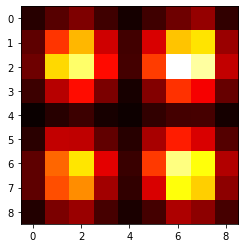

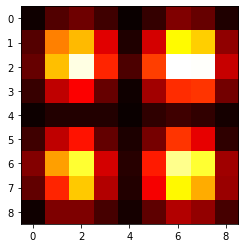

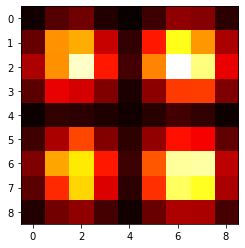

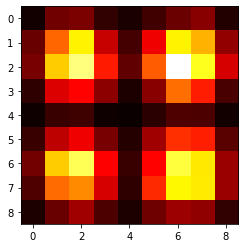

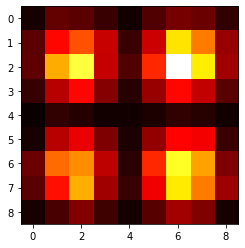

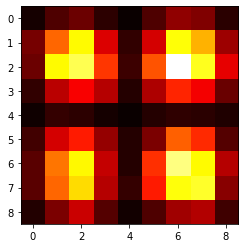

In [28]:
i=0
for sample in samples:
    plt.figure(i)
    i += 1
    plt.imshow(sample, cmap='hot')